<a href="https://colab.research.google.com/github/EmmaCOo/Detection_of_Histopatholigic_Cancer_Pytorch/blob/main/Detection_of_Histopatholigical_Cancer_Pytorch(EDA_%26_CNN_model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Histopathologic Cancer Detection Using Convolutional Neural Network (CNN) -Pytorch**

#####**REQUIRED LIBRARIES**

In [1]:
import numpy as np 
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import cv2
import re
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

import torch   #Pytorch library
import torchvision  #predefined Pytorch useful functions for computer vision problem
from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import torch.optim as optim
from torch.optim import lr_scheduler

#####**LOADING TRAIN AND TEST IMAGES FROM KAGGLE USING API COMMAND**

In [2]:
from google.colab import files
files.upload()
#upload kagge.json api file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emmaoo","key":"217582cb5d6aadd9b3c7fd6c51180a78"}'}

In [3]:
!pip install -q kaggle

In [4]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

#####**DATASET**

In [5]:
#download images from www.kaggle.com
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [00:26<00:00, 283MB/s]
100% 6.31G/6.31G [00:26<00:00, 252MB/s]


In [6]:
#unzip dataset images into csv file
!unzip histopathologic-cancer-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d

In [7]:
#load the data set's id and label into df
df = pd.read_csv('train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


####**EXPLORATORY DATA ANALYSIS (EDA)**

In [8]:
#check dimension of the dataset
df.shape

(220025, 2)

In [9]:
#check any duplicated data
df.duplicated().sum()

0

In [10]:
#check any class imbalance
df['label'].value_counts(normalize=True)*100

0    59.496875
1    40.503125
Name: label, dtype: float64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


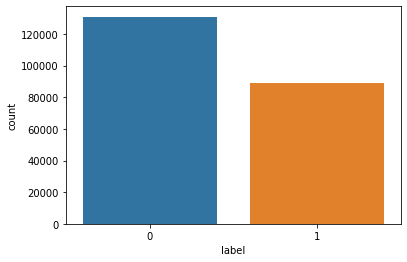

In [11]:
sns.countplot(df['label'])

####**Severe class imbalance is not observed in the dataset**

#####**VISUALIZATION OF IMAGES**

In [12]:
#define train and test paths
train_path = '/content/train'
test_path = '/content/test'

In [13]:
#define reading the images function
def readImage(path):
    bgr_img = cv2.imread(path)  #read the image in BGR format
    b,g,r = cv2.split(bgr_img)  
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

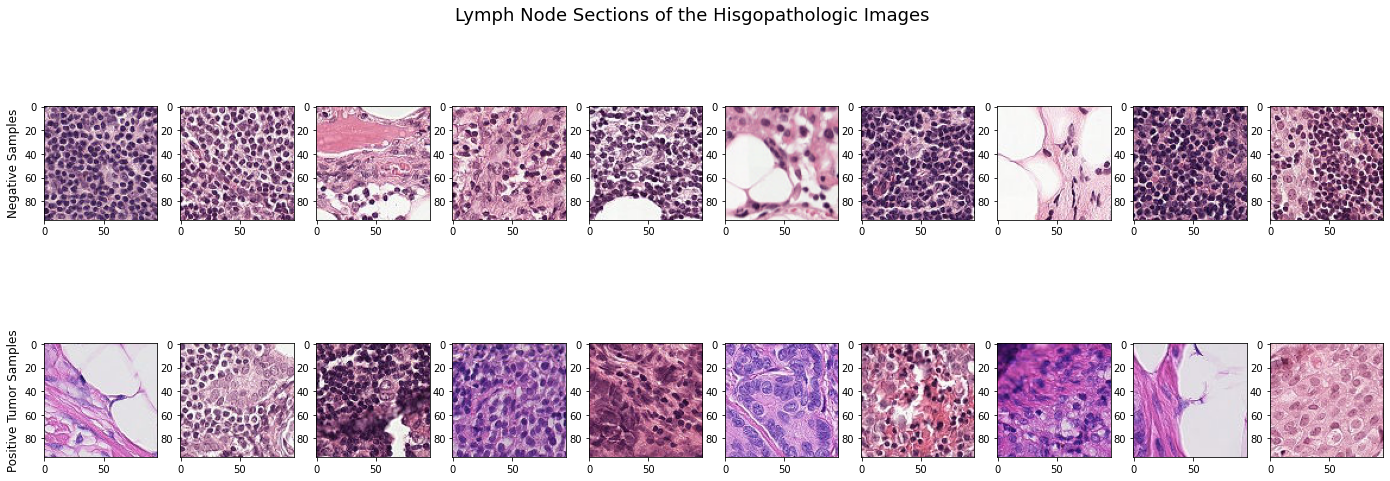

In [14]:
#Random sampling (shuffling) of images
shuffled_data = shuffle(df)

fig, ax = plt.subplots(2,10, figsize=(24,8))
fig.suptitle('Lymph Node Sections of the Hisgopathologic Images',fontsize= 18)

# Negative (normal) samples
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:10]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    ax[0,0].set_ylabel('Negative Samples', size='large')


# Positive (tumor) samples
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:10]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    ax[1,0].set_ylabel('Positive Tumor Samples', size='large')


#####**Visualization of the images show the morphological differecnes between postiive and negative samples. Pathologists usually get intense training to see the difference between them.  Thus, it's hard for the untrained person to differentiate between positive and negative without any training.**  

####**DATA PARTITIONING**
Let's split 90% train and 10% test data set using stratify method. 

In [15]:
train, test = train_test_split(df, test_size = 0.1, stratify = df['label'], random_state = 7)
len(train), len(test)

# #Splitting data into train and val
# train, val = train_test_split(labels, stratify=labels.label, test_size=0.1)
# len(train), len(val)

(198022, 22003)

In [16]:
print(train.shape, test.shape)

(198022, 2) (22003, 2)


In [17]:
train.head()

,id,label
62256,3c027ee2aa695ceba4033f870ec80dfa4a6caf06,0
136420,09f893feb6535604beaafa5cd4f735da4d946d2c,1
10261,ce98a9991dbdd7b732fa2cd9010d19f58262e4b0,0
180604,83a4ebc48118ab7763441f9c38de56713ee683c8,1
42131,b4b2dfed774730a3a07bbf46f85f81065bcfef36,0


####**MODELING**


#####**CONVOLUTIONAL NEURAL NETWORK (CNN) MODEL**




In [18]:
## Parameters for model

# Hyper parameters
num_epochs = 8 
num_classes = 2
batch_size = 128
learning_rate = 0.002

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#####**PREPARATION OF DATASET TO GET TRAINED BY CNN MODEL**

1) Dataset retrieves dataset's features and labels one sameple at a time.

2) Dataloader makes sure to pass the samples in minibatches, reshuffle the data for every iteration to minimize the model overfitting and speed up the process. 


In [19]:
# Define function fo simple custom generator

class MyDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [20]:
#Define transformation function
trans_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

trans_test = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

#Transform train and test dataset
dataset_train = MyDataset(df_data=train, data_dir=train_path, transform=trans_train)
dataset_test = MyDataset(df_data=test, data_dir=train_path, transform=trans_test)

#prepare the transformed data for training with Dataloader
loader_train = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
loader_test = DataLoader(dataset = dataset_test, batch_size=batch_size//2, shuffle=False, num_workers=0)

#####**CNN MODEL**
*  CNN is mainly used model in image processing applications. 

* Pytorch's torch.nn.Module was used. 

* Conv2d for two fully convolution laywers, maxpooling, and Relu activation function were used for CNN model using torch.nn.Module from Pytorch.  

**Dictionary for the terms used in CNN model**

* Conv2d = 2 Convolution layers

* in_channels = No of channels in the input images

* out_channels = No of channles generated by the convolution process

* kernel_size = Size of the convolving kernel.

* padding = size of the padding  (convolutional layers reduce the size of the output.  In the following code, the size of the output will be (2,2). 

* stride = No of pixels to pass at a time when slideing the convolutional kernel 

In [21]:
#define CNN model

class SimpleCNN(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(8)
        self.fc = nn.Linear(512 * 1 * 1, 2) # !!!
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.avg(x)
        #print(x.shape) # lifehack to find out the correct dimension for the Linear Layer
        x = x.view(-1, 512 * 1 * 1) # !!!
        x = self.fc(x)
        return x

In [22]:
model = SimpleCNN().to(device)
model

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc): Line

In [23]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

In [24]:
train.shape

(198022, 2)

In [25]:
# Train the model
total_step = len(loader_train)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(loader_train):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs,labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/8], Step [100/1548], Loss: 0.4238
Epoch [1/8], Step [200/1548], Loss: 0.3805
Epoch [1/8], Step [300/1548], Loss: 0.3118
Epoch [1/8], Step [400/1548], Loss: 0.4112
Epoch [1/8], Step [500/1548], Loss: 0.4094
Epoch [1/8], Step [600/1548], Loss: 0.2760
Epoch [1/8], Step [700/1548], Loss: 0.3435
Epoch [1/8], Step [800/1548], Loss: 0.3572
Epoch [1/8], Step [900/1548], Loss: 0.2762
Epoch [1/8], Step [1000/1548], Loss: 0.2671
Epoch [1/8], Step [1100/1548], Loss: 0.3486
Epoch [1/8], Step [1200/1548], Loss: 0.3079
Epoch [1/8], Step [1300/1548], Loss: 0.3658
Epoch [1/8], Step [1400/1548], Loss: 0.3244
Epoch [1/8], Step [1500/1548], Loss: 0.2981
Epoch [2/8], Step [100/1548], Loss: 0.3984
Epoch [2/8], Step [200/1548], Loss: 0.2456
Epoch [2/8], Step [300/1548], Loss: 0.3057
Epoch [2/8], Step [400/1548], Loss: 0.2641
Epoch [2/8], Step [500/1548], Loss: 0.2427
Epoch [2/8], Step [600/1548], Loss: 0.2296
Epoch [2/8], Step [700/1548], Loss: 0.1928
Epoch [2/8], Step [800/1548], Loss: 0.2281
Epoch

In [26]:
#Evaluate the model on the test dataset 

model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loader_test:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))


Test Accuracy of the model: 94.6961777939372 %
